<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap10/10_5_Convolution_For_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial 1a: MNIST-2D Classification**

This tutorial builds a proper network for 2D convolution.  It works with the MNIST dataset, which was the original classic dataset for classifying images.  The network will take a 28x28 grayscale image and classify it into one of 10 classes representing a digit.

The code is adapted from https://nextjournal.com/gkoehler/pytorch-mnist and https://github.com/udlbook/udlbook/blob/main/Notebooks/Chap10/10_5_Convolution_For_MNIST.ipynb

Work through the cells below, running each cell in turn.


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

## Data Loading in PyTorch

In this section, we are setting up the data loaders for the MNIST dataset, which is a collection of handwritten digits commonly used for training various image processing systems. The MNIST dataset is available in PyTorch through the `torchvision` package.

### Train DataLoader
- **Batch Size for Training:** `batch_size_train = 64`  
  This specifies that each batch of data that will be fed to the model during training contains 64 images.

- **DataLoader for Training Data:**  
  `train_loader` is an instance of `torch.utils.data.DataLoader`. It is responsible for loading the training data in batches. Here's how it's configured:
  - **Dataset:** We use `torchvision.datasets.MNIST`, specifying the `/files/` directory for storage, setting `train=True`, and enabling `download=True` to download the data if it's not already present.
  - **Transformations:**
    - `torchvision.transforms.ToTensor()`: Converts the images into PyTorch tensors.
    - `torchvision.transforms.Normalize((0.1307,), (0.3081,))`: Normalizes the tensor with a mean of 0.1307 and a standard deviation of 0.3081. These values are standard for MNIST.
  - **Shuffling:** The data is shuffled (`shuffle=True`) to ensure that each batch is different, helping the model to generalize better.

### Test DataLoader
- **Batch Size for Testing:** `batch_size_test = 1000`  
  For testing, we use a larger batch size of 1000 since gradients are not backpropagated and thus, less memory is required.

- **DataLoader for Test Data:**  
  `test_loader` is similar to `train_loader` but with `train=False` in the MNIST dataset loader. It loads the test data in batches to evaluate the model. The same transformations are applied as in the training data loader.

Both these data loaders will be used in the training and evaluation of a neural network model on the MNIST dataset.


In [ ]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 420640751.57it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 91908720.66it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 178033552.92it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17429578.01it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



## Visualizing MNIST Dataset Samples

In this section, we are visualizing some samples from the MNIST test dataset. This helps in understanding the type of data we are dealing with, which is crucial for designing and debugging neural network models.

### Extracting Data Samples
- `examples = enumerate(test_loader)`: Here, we create an iterable from the `test_loader`. This allows us to go through the batches in the test dataset.
- `batch_idx, (example_data, example_targets) = next(examples)`: This line retrieves the first batch from the test dataset. `batch_idx` is the index of the batch, `example_data` contains the images, and `example_targets` contains the corresponding labels.

### Plotting the Images
- `fig = plt.figure()`: We start by creating a new figure for plotting.
- The loop `for i in range(6):` iterates through the first six images in the batch.
  - `plt.subplot(2,3,i+1)`: Creates a subplot for each image. The images are arranged in a 2x3 grid, and `i+1` is the position index in this grid.
  - `plt.tight_layout()`: Adjusts the layout so that the plots are neatly arranged.
  - `plt.imshow(example_data[i][0], cmap='gray', interpolation='none')`: Displays the `i`-th image. The `[0]` accesses the first channel of the image (since MNIST images are grayscale). `cmap='gray'` sets the color map to grayscale, and `interpolation='none'` displays the image without interpolating pixel values.
  - `plt.title("Ground Truth: {}".format(example_targets[i]))`: Sets the title of each subplot to show the actual label (ground truth) of the image.
  - `plt.xticks([])` and `plt.yticks([])`: These commands remove the x and y-axis ticks for a cleaner look.

- `plt.show()`: Finally, this command displays the figure with the six MNIST images and their labels.

This visualization is a great way to verify that the data loading process is working correctly and to get a sense of the MNIST dataset's contents.


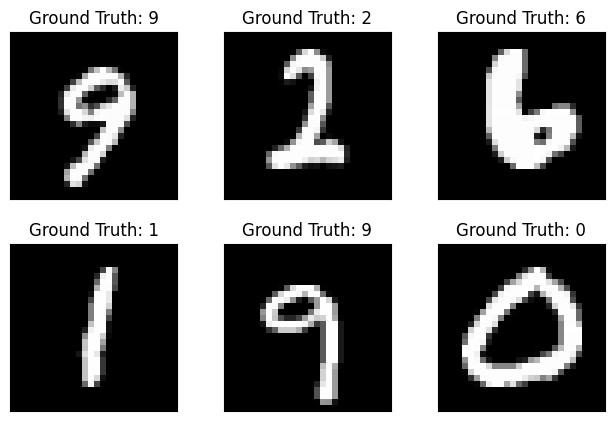

In [ ]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

## Custom Neural Network Architecture in PyTorch

The following code snippet is a template for a custom neural network class in PyTorch, with a set of instructions to implement specific layers and operations.

### Implementation of `Net` Class
- The `Net` class is derived from `nn.Module`, which is a base class for all neural network modules in PyTorch.
- **Constructor (`__init__`):**
  - `self.conv1 = nn.Conv2d(1, 2, kernel_size=3)`: A convolutional layer with a kernel size of 3, 1 input channel, and 2 output channels.
  - `self.drop = nn.Dropout2d()`: A dropout layer that randomly zeroes some of the elements of the input tensor with a default probability of 0.5 during training, which helps prevent overfitting.
  - `self.fc1 = nn.Linear(338, 10)`: A fully connected (linear) layer that maps from 338 input features to 10 output features.
- **Forward Pass (`forward`):**
  - The forward pass defines how the input `x` flows through the network layers.
  - `x` goes through the convolutional layer, dropout, max pooling, ReLU activation, flattening, fully connected layer, and finally a log softmax function.


In [ ]:
from os import X_OK

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Valid convolution, 1 channel in, 2 channels out, stride 1, kernel size = 3
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3)
        # Dropout for convolutions
        self.drop = nn.Dropout2d()
        # Fully connected layer
        self.fc1 = nn.Linear(338, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.drop(x)
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.log_softmax(x)
        return x

## He Initialization in PyTorch

In this section, we define a function `weights_init` to apply He initialization (also known as Kaiming initialization) to the weights of linear layers in a neural network. This initialization method is particularly effective for layers followed by ReLU activations.

### Function: `weights_init`
- **Purpose:** This function is designed to initialize the weights of linear layers in a neural network using He initialization.
- **Parameter:** `layer_in`
  - The function takes a layer (`layer_in`) as its input.
- **He Initialization:**
  - `nn.init.kaiming_uniform_(layer_in.weight)`: If the layer is an instance of `nn.Linear`, its weights are initialized using the Kaiming uniform initialization. This method sets the weights uniformly in the range \([-a, a]\). See [TORCH.NN.INIT](https://pytorch.org/docs/stable/nn.init.html) for details.
  - `layer_in.bias.data.fill_(0.0)`: The bias terms of the layer are initialized to 0.

### Why Use He Initialization?
- **Avoiding Vanishing/Exploding Gradients:** In deep networks, improper initialization can lead to the problem of vanishing or exploding gradients. This happens when the gradients are too small or too large, making the network difficult or impossible to train.
- **Relevance to ReLU:** He initialization is particularly effective when the network uses ReLU activation functions. It helps in maintaining a variance of 1 in the outputs of each layer, preventing the gradients from becoming too small during backpropagation.
- **Balanced Initial Weights:** By initializing the weights from a uniform distribution and considering the size of the previous layer, He initialization provides a good starting point for the learning process. This can lead to faster convergence during training and improved overall performance of the neural network.


In [ ]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

## Initializing and Setting Up the Neural Network

In this code snippet, we are creating and initializing a neural network model, and then defining its optimizer. This setup is essential for preparing the model for the training process.

### Network Creation
- `model = Net()`: This line creates an instance of the `Net` class, which defines our neural network.

### Weight Initialization
- `model.apply(weights_init)`: Here, the `weights_init` function is applied to all the layers of the model. This function should be defined to initialize the weights of the network appropriately. In the context of neural networks, proper weight initialization can significantly impact the convergence and overall performance of the network during training.

### Optimizer Definition
- `optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)`: This line defines the optimizer for the training process. Specifically, it:
  - Uses the Stochastic Gradient Descent (SGD) algorithm from PyTorch's `optim` package.
  - `model.parameters()`: Passes all the parameters of the model (weights and biases) to the optimizer.
  - `lr=0.01`: Sets the learning rate to 0.01. The learning rate controls how much to change the model in response to the estimated error each time the model weights are updated.
  - `momentum=0.5`: Sets the momentum to 0.5. Momentum helps accelerate the optimizer in the relevant direction and dampens oscillations.

In [ ]:
# Create network
model = Net()
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
print(model)

Net(
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=338, out_features=10, bias=True)
)


## Training Routine for the Neural Network

This section of code outlines the main training routine for our neural network model.

### Function: `train`
- **Purpose:** The `train` function is designed to train the model for one epoch. An epoch is one complete pass through the training dataset.
- **Parameter:** `epoch`  
  This parameter represents the current epoch number.

### Training Process
- `model.train()`: This line sets the model to training mode. This is important because certain layers like dropout layers behave differently during training than during testing.
- **Iterating Over Batches:**
  - `for batch_idx, (data, target) in enumerate(train_loader)`: This loop iterates over the training data using the `train_loader`. `batch_idx` is the index of the current batch, `data` contains the input data, and `target` contains the corresponding labels.
- **Optimization Steps:**
  - `optimizer.zero_grad()`: Before the model performs backpropagation, we need to clear the existing gradients; otherwise, they will accumulate.
  - `output = model(data)`: The model computes its predictions based on the current batch of data.
  - `loss = F.nll_loss(output, target)`: The loss is calculated using the negative log likelihood loss function, which is common for classification tasks.
  - `loss.backward()`: This line computes the gradient of the loss with respect to all trainable parameters in the model.
  - `optimizer.step()`: The optimizer updates the weights based on the computed gradients.
- **Logging:**
  - The `if` condition `if batch_idx % 10 == 0:` checks if the current batch index is a multiple of 10. If so, it prints out the current training status, including the epoch, the number of data processed so far, the total size of the dataset, and the current loss.

In [ ]:
# Main training routine
def train(epoch):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

## Evaluating the Neural Network on Test Data

This section of the code defines the `test` function, which is used to evaluate the performance of the neural network model on the test dataset.

### Function: `test`
- **Purpose:** The function assesses the model's performance on the test dataset by calculating the average loss and the accuracy.

### Testing Process
- `model.eval()`: This line sets the model to evaluation mode. It is important as certain layers like dropout layers behave differently during evaluation than during training.
- **Initialization:**
  - `test_loss = 0`: A variable to accumulate the loss over the test dataset.
  - `correct = 0`: A counter for the number of correct predictions.
- **No Gradient Calculations:**
  - `with torch.no_grad()`: This context manager disables gradient calculation, which reduces memory consumption and speeds up computations, since gradients are not needed for evaluation.
- **Iterating Over the Test Data:**
  - `for data, target in test_loader`: This loop iterates over the test data using `test_loader`. `data` contains the input data, and `target` contains the corresponding labels.
  - `output = model(data)`: The model makes predictions based on the current batch of data.
  - `test_loss += F.nll_loss(output, target, size_average=False).item()`: The loss is calculated using the negative log likelihood loss function and accumulated.
  - `pred = output.data.max(1, keepdim=True)[1]`: The predictions are obtained by finding the index of the maximum log-probability.
  - `correct += pred.eq(target.data.view_as(pred)).sum()`: Counts the number of correct predictions by comparing `pred` with the actual `target`.
- **Final Loss and Accuracy Calculation:**
  - `test_loss /= len(test_loader.dataset)`: The total loss is averaged over the number of examples in the test dataset.
  - The final print statement reports the average test loss and the accuracy of the model.



In [ ]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# Get initial performance
test()
# Train for three epochs
n_epochs = 3
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-4-e89a9d90efd6>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.4132, Accuracy: 892/10000 (9%)

Train Epoch: 1 [0/60000]	Loss: 2.390304
Train Epoch: 1 [640/60000]	Loss: 2.365330
Train Epoch: 1 [1280/60000]	Loss: 2.317568
Train Epoch: 1 [1920/60000]	Loss: 2.295605
Train Epoch: 1 [2560/60000]	Loss: 2.280946
Train Epoch: 1 [3200/60000]	Loss: 2.261410
Train Epoch: 1 [3840/60000]	Loss: 2.248566
Train Epoch: 1 [4480/60000]	Loss: 2.245144
Train Epoch: 1 [5120/60000]	Loss: 2.076128
Train Epoch: 1 [5760/60000]	Loss: 2.060066
Train Epoch: 1 [6400/60000]	Loss: 1.954514
Train Epoch: 1 [7040/60000]	Loss: 1.945989
Train Epoch: 1 [7680/60000]	Loss: 1.823616
Train Epoch: 1 [8320/60000]	Loss: 1.811078
Train Epoch: 1 [8960/60000]	Loss: 1.708416
Train Epoch: 1 [9600/60000]	Loss: 1.712904
Train Epoch: 1 [10240/60000]	Loss: 1.293424
Train Epoch: 1 [10880/60000]	Loss: 1.644754
Train Epoch: 1 [11520/60000]	Loss: 1.601322
Train Epoch: 1 [12160/60000]	Loss: 1.260821
Train Epoch: 1 [12800/60000]	Loss: 1.024196
Train Epoch: 1 [13440/60000]	Loss: 1.248

## Visualizing Convolutional Filters in a Neural Network

The `visualize_filters` function is designed to extract and display the filters from the first convolutional layer of a provided neural network model. This visualization can be quite helpful in understanding what features your convolutional neural network is learning.

### Function: `visualize_filters`
- **Purpose:** To visually inspect the filters in the first convolutional layer of the neural network.
- **Parameter:** `model`  
  The neural network model whose filters are to be visualized.

### Visualization Process
- **Extract Filters:**
  - `conv1_weights = model.conv1.weight.data.numpy()`: This line extracts the weights of the first convolutional layer (`conv1`) of the model and converts them into a NumPy array. These weights represent the filters.
- **Determine Number of Filters:**
  - `num_filters = conv1_weights.shape[0]`: Determines the number of filters in the convolutional layer by checking the first dimension of the `conv1_weights` array.
- **Plotting:**
  - `fig = plt.figure(figsize=(10, 5))`: Creates a new figure for plotting with a specified size.
  - The loop `for i in range(num_filters):` iterates through each filter.
    - `ax = fig.add_subplot(1, num_filters, i+1)`: Creates a subplot for each filter in a 1-row grid.
    - `ax.imshow(conv1_weights[i, 0, :, :], cmap='gray')`: Displays the `i`-th filter. The filters are shown in grayscale for easier interpretation.
    - `ax.set_title('Filter {}'.format(i+1))`: Sets a title for each subplot indicating the filter number.
    - `plt.xticks([])` and `plt.yticks([])`: These commands remove the x and y-axis ticks for a cleaner look of each filter.
  - `plt.show()`: Displays the figure with all the filters.

### Execution
- `visualize_filters(model)`: This line calls the `visualize_filters` function with the neural network model `model` as an argument, which will execute the visualization of the filters in the model's first convolutional layer.


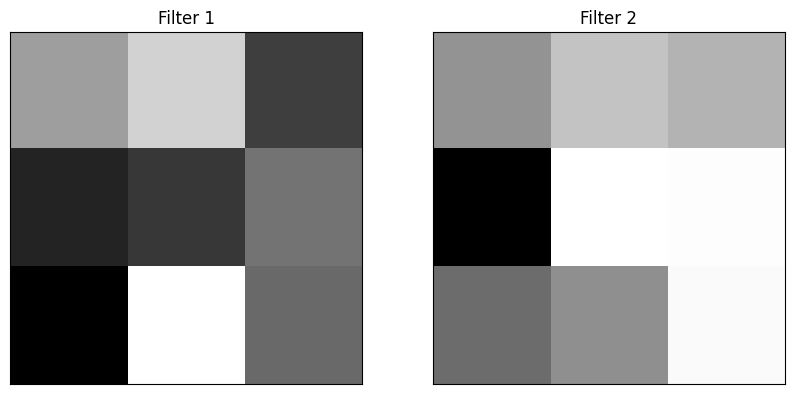

In [ ]:
def visualize_filters(model):
    # Extract the weights from the first convolutional layer
    conv1_weights = model.conv1.weight.data.numpy()

    # Number of filters
    num_filters = conv1_weights.shape[0]

    fig = plt.figure(figsize=(10, 5))
    for i in range(num_filters):
        ax = fig.add_subplot(1, num_filters, i+1)
        # Display each filter
        ax.imshow(conv1_weights[i, 0, :, :], cmap='gray')
        ax.set_title('Filter {}'.format(i+1))
        plt.xticks([])
        plt.yticks([])

    plt.show()

visualize_filters(model)

<ipython-input-4-4e4b7d3d78d6>:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


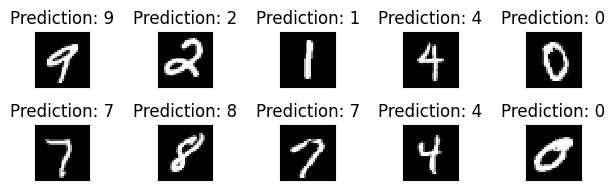

In [ ]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()

## What's Next?

We have sketched a simple framework for training CNNs. There are a few more functions yet to be completed.

  - Adjust the learning rate and batch size and observe the training curve
  - Plot a chart for the accuracy
  - Average the loss during each epoch when plotting a chart
  - Consider data augmentations

Please check the official [Tutorials](https://pytorch.org/tutorials) and [Examples](https://github.com/pytorch/examples) on for more details.